In [29]:
import xarray as xr
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import *
%load_ext autoreload
%autoreload 3
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from helpers.collection_of_experiments import *

In [31]:
ds = CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/Feb2022/bare', additional_subfolder='output')
ds += CollectionOfExperiments.init_folder('/home/ctrsp-2024/pp2681/experiments/generalization', additional_subfolder='output')

In [32]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR)

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8


In [33]:
for RR in ['R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8']:
    ds.remesh('R64', RR, operator=gaussian_remesh, FGR=np.sqrt(6), exp=f'R64_{RR}_FGR-sqrt6')

Experiment R64 coarsegrained to R2 is created. Its identificator=R64_R2_FGR-sqrt6
Experiment R64 coarsegrained to R3 is created. Its identificator=R64_R3_FGR-sqrt6
Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4_FGR-sqrt6
Experiment R64 coarsegrained to R5 is created. Its identificator=R64_R5_FGR-sqrt6
Experiment R64 coarsegrained to R6 is created. Its identificator=R64_R6_FGR-sqrt6
Experiment R64 coarsegrained to R7 is created. Its identificator=R64_R7_FGR-sqrt6
Experiment R64 coarsegrained to R8 is created. Its identificator=R64_R8_FGR-sqrt6


In [34]:
for RR in ['R2', 'R4', 'R5', 'R6', 'R7', 'R8']:
    for file in [f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt6-part1.nc', 
                 f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt6-part2.nc',
                 f'/home/ctrsp-2024/pp2681/notebooks/filtered-data/R64_{RR}_FGR-sqrt6-part3.nc']:
            dataset = xr.open_dataset(file, decode_times=False)
            for key in dataset.keys():
                var = dataset[key]
                var['Time'] = ds['R64'].u['Time']
                setattr(ds[f'R64_{RR}_FGR-sqrt6'], key, var)

# The purpose of this notebook is to take an unsuccesful simulation and apply dynamic procedure in the box. Then to analyze every part separately so we can know if there is transfer to grid scales

In [35]:
RR = 'R6'
fDNS = ds[f'R64_{RR}_FGR-sqrt6']
SGS_transfer = fDNS.transfer(fDNS.SGSx, fDNS.SGSy)
SGS_CA_transfer = fDNS.transfer(fDNS.SGS_CAu, fDNS.SGS_CAv)

In [36]:
online = ds['zelong-True-three-component-reduce-1-R6']
DbMM_Reynolds_clip_on_fDNS = fDNS.dynamic_model_SSD(ssm=True, reynolds=True, clip=True)
DbMM_Reynolds_clip_on_online = online.dynamic_model_SSD(ssm=True, reynolds=True, clip=True)

In [37]:
SGS_dict = {}
SGS_dict['DbMM_Reynolds_clip_on_fDNS'] = fDNS.transfer(DbMM_Reynolds_clip_on_fDNS['dudt'], DbMM_Reynolds_clip_on_fDNS['dvdt']).compute()
SGS_dict['DbMM_Reynolds_clip_on_online'] = online.transfer(DbMM_Reynolds_clip_on_online['dudt'], DbMM_Reynolds_clip_on_online['dvdt']).compute()

In [38]:
SGS_dict['DbMM_Reynolds_clip_online'] = online.Smagorinsky_transfer.compute()

In [39]:
SGS_dict['DbMM_Reynolds_clip_on_online_ssm'] = online.transfer(DbMM_Reynolds_clip_on_online['leo_y'], -DbMM_Reynolds_clip_on_online['leo_x']).compute()

In [40]:
SGS_dict['DbMM_Reynolds_clip_on_online_rey'] = online.transfer(20*DbMM_Reynolds_clip_on_online['by_base'], -20*DbMM_Reynolds_clip_on_online['bx_base']).compute()

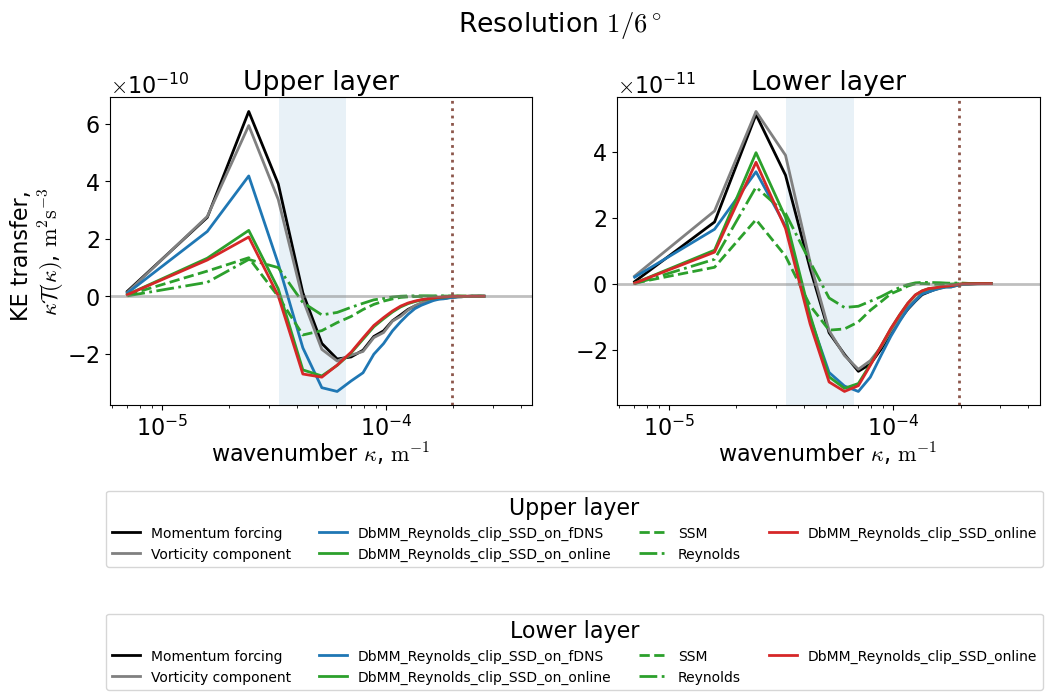

In [43]:
def compensated(sp):
    return sp * sp.freq_r

default_rcParams({'font.size':16, 'figure.subplot.wspace': 0.2, 'figure.subplot.hspace': 0.15})
zl=0
fig = plt.figure(figsize=(12,4))

colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]

for zl in [0,1]:
    plt.subplot(1,2,1+zl)
    compensated(SGS_transfer).isel(zl=zl).plot(color='k', lw=2, label='Momentum forcing')
    compensated(SGS_CA_transfer).isel(zl=zl).plot(color='gray', lw=2, label='Vorticity component')
    compensated(SGS_dict['DbMM_Reynolds_clip_on_fDNS']).isel(zl=zl).plot(lw=2, color=colors[0], 
                label='DbMM_Reynolds_clip_SSD_on_fDNS')
    compensated(SGS_dict['DbMM_Reynolds_clip_on_online']).isel(zl=zl).plot(lw=2, ls = '-', color=colors[2], 
                label='DbMM_Reynolds_clip_SSD_on_online')
    compensated(SGS_dict['DbMM_Reynolds_clip_on_online_ssm']).isel(zl=zl).plot(lw=2, ls = '--', color=colors[2], 
                label='SSM')
    compensated(SGS_dict['DbMM_Reynolds_clip_on_online_rey']).isel(zl=zl).plot(lw=2, ls = '-.', color=colors[2], 
                label='Reynolds')
    compensated(SGS_dict['DbMM_Reynolds_clip_online']).isel(zl=zl).plot(lw=2, ls = '-', color=colors[3], 
                label='DbMM_Reynolds_clip_SSD_online')

    plt.axhline(y=0,color='gray', alpha=0.5, lw=2)
    Rd1 = 30000
    Rd2 = 15000
    plt.axvspan(1/Rd1, 1/Rd2, color='tab:blue', alpha=0.1, lw=0)
    plt.xscale('log')
    plt.xlabel('')
    dx = len(ds['R64'].h.xh) / len(fDNS.h.xh) * 1500 # in metres
    plt.xlim([None, 4.5e-4])
    #plt.xticks([1e-5, 1e-4, 1e-3])
    plt.xlabel('wavenumber $\kappa$, $\mathrm{m}^{-1}$')


    if zl==0:
        plt.ylabel('KE transfer, \n$\kappa \mathcal{T}(\kappa)$, $\mathrm{m}^2\mathrm{s}^{-3}$')
        plt.title('Upper layer')
        #plt.ylim([-0.5e-9,0.5e-9])
        #plt.yticks(np.linspace(-1e-9,1e-9,5))
        plt.axvline(x=np.pi/dx, ls=':', color='tab:brown', lw=2)
    else:
        #plt.ylim([-0.5e-10,0.5e-10])
        #plt.yticks(np.linspace(-1e-10,1e-10,5))
        plt.axvline(x=np.pi/dx, ymin=0.0, ls=':', color='tab:brown', lw=2)
        plt.title('Lower layer')
        #plt.text(3.3e-5,-1.2e-10,'Deformation \n     radius \n  $15-30$ km', fontsize=12, color='tab:blue')
        #plt.text(np.pi/dx, -1.2e-10, 'Grid scale\n   $\\pi/\\Delta x$', fontsize=12, color='tab:brown')

    if zl==0:
        plt.legend(bbox_to_anchor=(1.1,-0.4), loc='center', ncol=4, fontsize=10, title='Upper layer')
    else:
        plt.legend(bbox_to_anchor=(-0.1,-0.8), loc='center', ncol=4, fontsize=10, title='Lower layer')
plt.suptitle('Resolution $1/6^\circ$', y=1.1)
plt.savefig('figures/onset_of_instabilities_R6.pdf')